In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval as make_tuple

In [2]:
import os
import time

#import TDA

import dionysus as d

import diode

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.cluster.hierarchy import dendrogram, average

import matplotlib
from matplotlib import cm

### Read all relevant data files 🦋

In [3]:
days = ["p2", "p3", "p4", "p5", "p6", "p7"]
filepath = "/Users/elyseborgert/Desktop/validation_data/feature_extraction/feature/"
plotspath = "/Users/elyseborgert/Desktop/"
alldata = [pd.read_excel("{}{}_alldata.xlsx".format(filepath,x), 
                         sheet_name="Sheet1", engine='openpyxl') for x in days]
degree = [pd.read_excel("{}{}_degreedata.xlsx".format(filepath,x), 
                        sheet_name="Sheet1", engine='openpyxl') for x in days]

### Generate np arrays
Returns list of centered np arrays, where each array corresponds to a day.

In [4]:
arrays_by_day = []
for df in degree:
    to_array = [make_tuple(x) for x in df["nodes"]]
    coords = np.array(to_array)
    coords = coords - np.mean(coords, axis=0)
    arrays_by_day.append(coords)

In [5]:
# Verify that the data is centered
for a in arrays_by_day:
    print(sum(a).round(6))

[-0.  0.]
[ 0. -0.]
[0. 0.]
[-0. -0.]
[-0. -0.]
[0. 0.]


In [6]:
arrays_by_day[5].shape

(3876, 2)

# iterate over days, compute PH using alpha shape filtration for each day

In [7]:
all_dgms = []

for array in arrays_by_day:
    coords = array
    simplices = diode.fill_alpha_shapes(coords,exact = True)
    #simplices = d.fill_rips(coords)
    # generate filtration with dionysus
    f = d.Filtration(simplices)

    # homology persistence
    m = d.homology_persistence(f)

    # store H1 barcodes
    dgms = d.init_diagrams(m,f)
    all_dgms.append(dgms[1])


    #convert barcodes to the easier formats
all_1bcs = []
for dgm in all_dgms:
    local_bc = []

    for bc in dgm:
        local_bc.append([bc.birth,bc.death])
    all_1bcs.append(local_bc)
            

# Plot results

In [10]:
#set up rainbow color scheme to color by day (p2 = red,...,p7=purple)
plot_cols = plt.get_cmap("rainbow")(np.linspace(0,1,num=len(days)))
plot_cols = plot_cols[::-1]

# Plot the barcodes for each day
The x-axis represents the radius of alpha and each bar represents a feature. The bar starts at the birth radius and ends at the death radius.
We plot each figure on the same scale to see how the number of bars / length of bars change over time

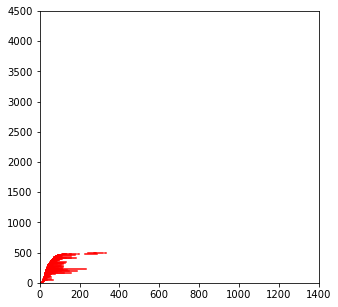

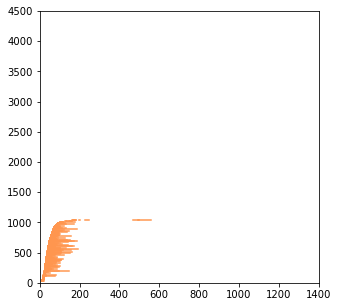

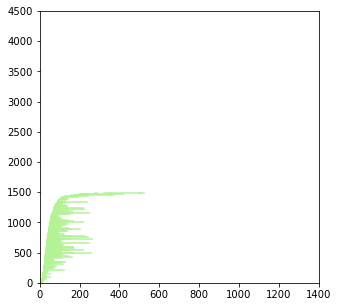

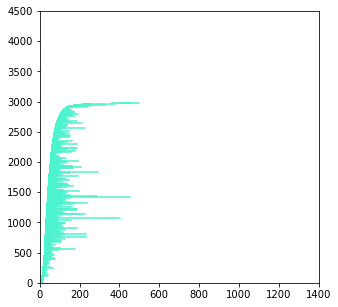

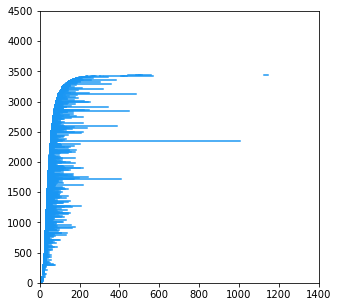

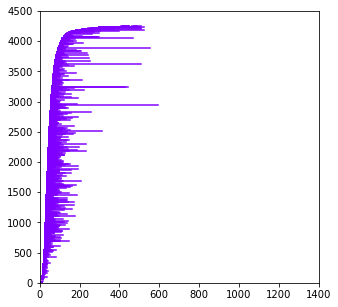

In [9]:
for i,bc in enumerate(all_1bcs):
    fig,ax= plt.subplots(figsize=(5, 5))
    for j,bar in enumerate(bc):
        x_values = bar
        y_values = [j,j]
        ax.plot(x_values,y_values,color=plot_cols[i])
        plt.xlim((0,1400))
        plt.ylim((0,4500))
    plt.savefig("{}{}_barcode.png".format(plotspath,days[i]))

# Persistence diagrams plotted for each day. Each point is the pair (birth_radius, death_radius)
We plot each figure on the same scale for comparison

In [11]:
for i,bc in enumerate(all_1bcs):
    fig,ax= plt.subplots(figsize=(5, 5))
    for j,bar in enumerate(bc):
        x = bar[0]
        y = bar[1]
        ax.scatter(x,y,color=plot_cols[i],s=2)
    plt.xlim((0,1400))
    plt.ylim((0,1400))
    xx= np.linspace(0,1400,10)
    ax.plot(xx,xx,color='black')
    plt.savefig("{}{}_PD.png".format(plotspath,days[i]))


Error in callback <function flush_figures at 0x7ff22d6d0b80> (for post_execute):


KeyboardInterrupt: 

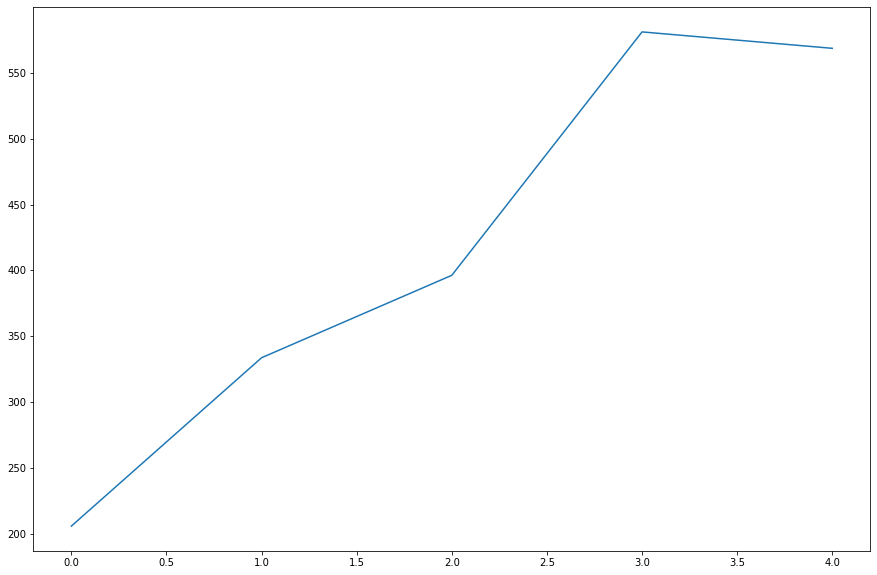

In [268]:
#seq Wasserstein distance btwn diagrams over time
seq_dist = []
for i in range(len(all_dgms)-1):
    seq_dist.append(d.wasserstein_distance(all_dgms[i], all_dgms[i+1], q=2))
                
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(list(range(0,len(seq_dist))),seq_dist)
plt.show()

# compute pairwise Wasserstein distances between diagrams and plot distance matrix

In [34]:
n = len(all_dgms)
dm = np.zeros((n,n))
for i in range(n-1):
    for j in range(i+1, n):
    #compute the 2-wass distance between PD_i and PD_j
        dm[i,j] = d.wasserstein_distance(all_dgms[i], all_dgms[j], q=2)
        dm[j,i] = dm[i,j]

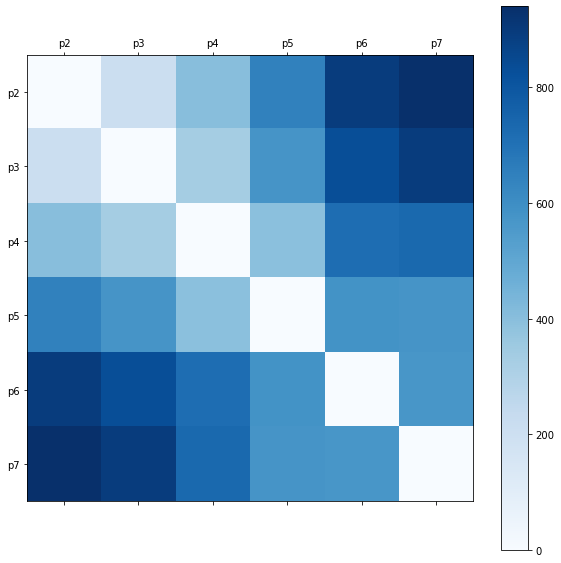

In [35]:
fig,ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(dm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticks(np.arange(len(days)))
ax.set_yticks(np.arange(len(days)))
ax.set_xticklabels(days)
ax.set_yticklabels(days)
plt.savefig("{}wass_dist_mat.png".format(plotspath))


# Embed the pairwise distance matrix in 2d using MDS and plot (colored by day)
points close together represent close components in the distance matrix, i.e. points close together represent days with similar PDs

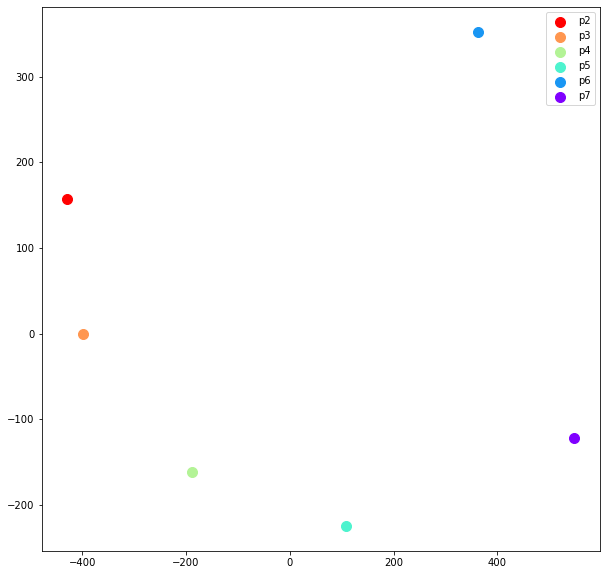

In [37]:
from sklearn import manifold as mfld
from sklearn import decomposition as decomp

#set up the MDS model to embed into 2d and accept a distance matrix as input 
embedding = mfld.MDS(n_components=2,dissimilarity = "precomputed")

#actually compute the embedding coords
embed_coords = embedding.fit_transform(dm)

#Python's mds doesn't automatically orient for principal components, so let's do that
pca = decomp.PCA(n_components=2)
embed_coords = pca.fit_transform(embed_coords)

#actually plot
fig,ax = plt.subplots(figsize=(10,10))
for i, day in enumerate(days):
    scatter = ax.scatter(embed_coords[i,0],embed_coords[i,1],color=plot_cols[i],s=100,label=day)
ax.legend()
plt.savefig("{}wass_dist_embed.png".format(plotspath))
